## What does TensorFlow offer?
* similar to NumPy but with GPU support
* supports distributed computing
* just-in-time compiler
  * optimizes computations for speed and memory
  * utilizes Python's computational graph
* computational graphs can be exported to a portable format
* implements autodiff

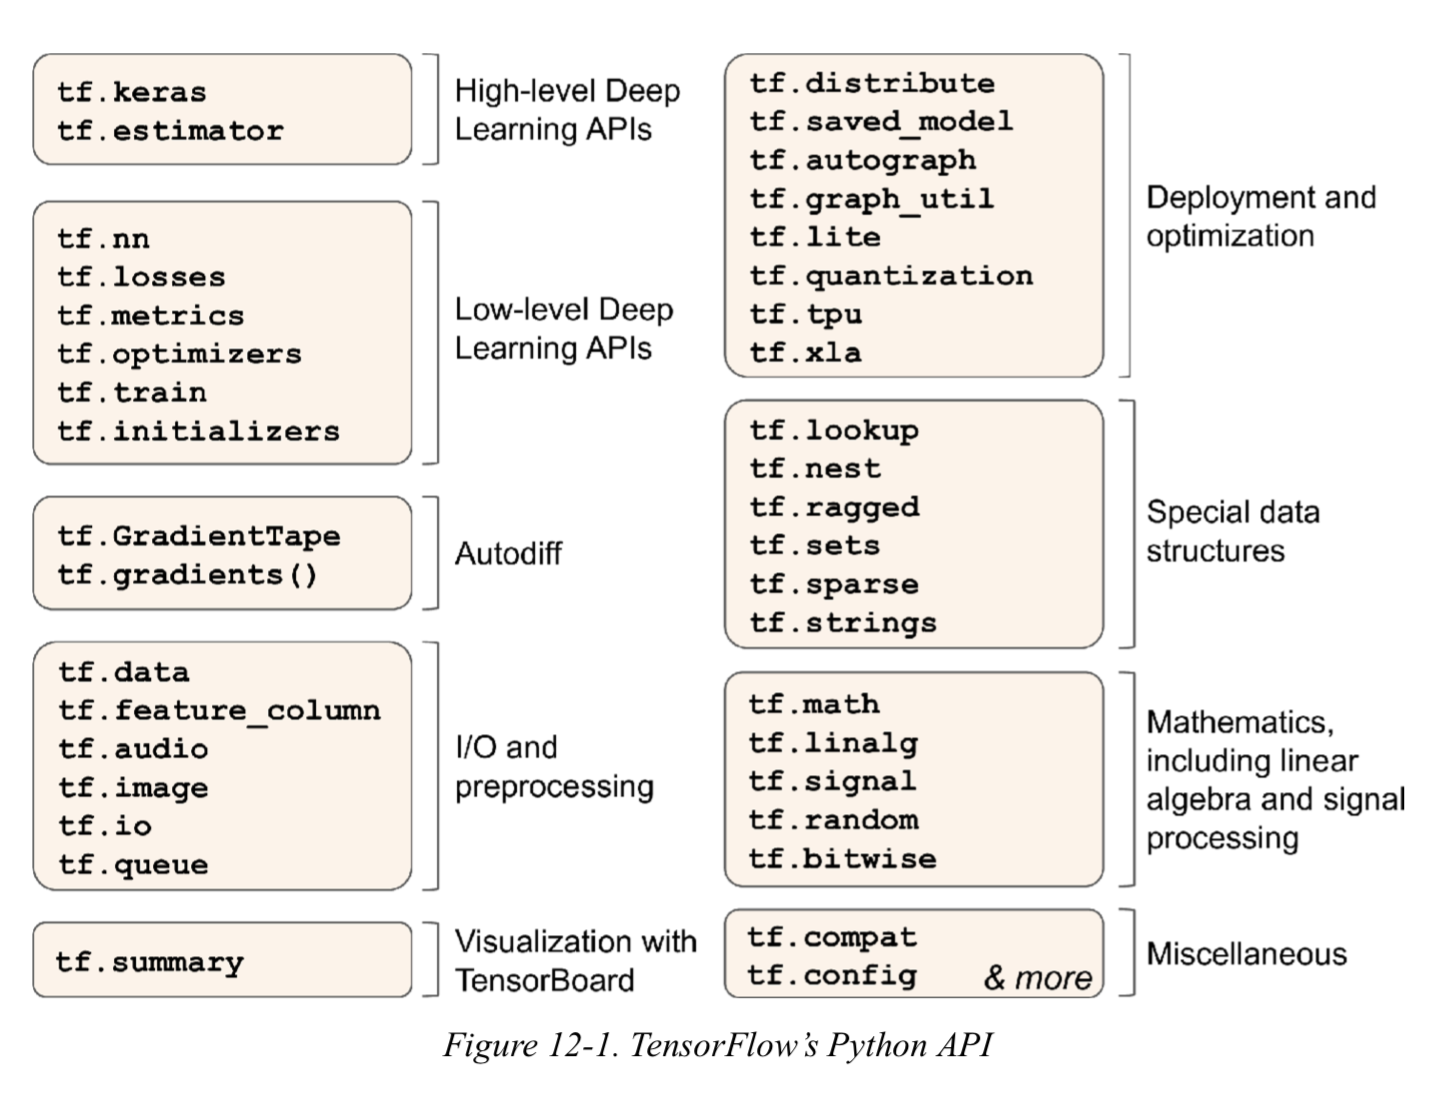

* at the lowest level, TF operations are implemented using efficient C++ code
* kernels: multiple implementations of operations
  * each kernel is dedicated to a specific device type (CPU, GPU, TPU, etc)
* TensorFlow
  * TFHub
  * TF Extended
  * model garden

## Using TensorFlow like NumPy
* tensor: multidimensional array -> Numpy

In [9]:
# Imports

import tensorflow as tf
import numpy as np

In [1]:
# Creating Tensors

tf.constant([[1., 2., 3.],[4., 5., 6.]])

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [2]:
# Creating a scalar as a Tensor 

tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [4]:
# Getting the shape and type of a tensor

t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
print(t.shape)
print(t.dtype)

(2, 3)
<dtype: 'float32'>


In [5]:
# Indexing a tensor

t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
# 

t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

* tf.reduce_sum() / tf.reduce_mean()
  * GPU kernel uses a reduce algorithm that does not add in any certain order

## Tensors and NumPy


In [10]:
# Creating tensor from a NumPy array

a = np.array([2., 4., 5.])
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [11]:
# Creating a NumPy array from a tensor

t.numpy()
# np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [12]:
# Applying tensor operations on NumPy arrays

tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [13]:
# Applying NumPy operations on tensors

np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

## Type Conversions
* type conversions hurt performance
  * tf checks for matching types before proceeding with operations

In [14]:
# Fails to add float and integer

tf.constant(2.) + tf.constant(40)

InvalidArgumentError: ignored

In [15]:
# Fails to add 32-bit float and 64 bit float

tf.constant(2.) + tf.constant(40., dtype=tf.float64)

InvalidArgumentError: ignored

In [16]:
# Using casting to convert types

t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

### Variables
* tf.tensors are immutable
  * immutable: cannot be modified
* Uses tf.Variable when values change over time

In [17]:
# Creating a tf variable

v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [18]:
# Modifying a tensor variable

## Multiplying a constant by the variable
v.assign(2*v)

## Changing a certain value 
v[0,1].assign(42)

## Changing an axis
v[:,2].assign([0., 1.])

## Updating certain indices
v.scatter_nd_update(indices=[[0,0], [1,2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

### Other Data Structures
* Sparse Tensors -> tf.SparseTensor
  * efficiently represent tensors containing mostly zeros
* Tensor arrays -> tf.TensorArray
  *  list of tensors
* Ragged tensors -> tf.RaggedTensor
  * static list of list of tensors
  * every tensor has same shape and data type
* String tensors
  * regular tensors with tyoe tf.string
    * byte strings not Unicode
      *  Unicode gets encoded automatically to UTF-8
        * use tf.int32 to use Unicode code point to represent an Unicode item
          * code point: use integer to represent a character
* Sets
* Queues
  * store tensors in multiple steps

## Customizing Models and Training Algorithms
### Custom Loss Functions
* MSE: penalizes large errors too much
* MAE: does not penalize large errors
  * might take training a while to converge
* Use Huber Loss
  * best of both MSE and MAE
    * reduces the outliers' impact on the loss
    * makes it differentiable

In [ ]:
# Implementing Huber Loss

## Function that calculates 
def huber_fn(y_true, y_pred):
  error = y_true - y_pred
  is_small_error = tf.abs(error) < 1
  squared_loss - tf.square(error)/2
  linear_loss = tf.abs(error) - 0.5
  return tf.where(is_small_error, squared_loss, linear_loss)

# ## Compiling model with huber loss function
# model.compile(loss=huber_fn, optimizer="nadam") 

### Saving and Loading Models That Contain Custom Components
* need to provide a dictionary that maps function name to actual function
  * custom objects -> object names


In [1]:
# Customizable Huber function

def create_huber(threshold=1.0):
  def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < threshold
    squared_loss = tf.square(error)/2
    linear_loss = threshold * tf.abs(error) - threshold**2/2
    return tf.where(is_small_error, squared_loss, linear_loss)
  return huber_fn

In [ ]:
# # Loading a model with a customized huber loss

# model = keras.model.load_model(
#   custom_objects={
#     "huber_fn":create_huber(2.0)
#   }
# )

In [ ]:
# Implementing by creating a subclass of keras.losses.Loss

class HuberLoss(keras.losses.Loss):
  
  ## Initializing variables
  def __init__(self, threshold=1.0, **kwargs):
    
    ### Initializing the variables that only pertains to this class 
    self.threshold = threshold

    ### Intializing all the variables it is getting from its parent class
    super().__init__(**kwargs)
  
  ## Calling the Huber function
  def call(self, y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < threshold
    squared_loss = tf.square(error)/2
    linear_loss = threshold * tf.abs(error) - threshold**2/2
    return tf.where(is_small_error, squared_loss, linear_loss)
  
  ## Getting the configs (mappings of the hyperparameters and its name) of this class
  def get_config(self):

    ### Getting all the configs from parent class
    base_config = super().get_config()

    ### Adding its own config and returning it
    return {**base_config, "threshold":self.threshold}

In [ ]:
# # Compiling the model with HuberLoss

# model.compile(loss=HuberLoss(2.), optimizer="nadam")

In [ ]:
# # Loading the model

# model = keras.models.load_model("my_model.h5", custom_objects={"HuberLoss":HuberLoss})

### Customizations
* loss
* activations, initializers, regularizers, and constraints
